# Setup and imports

In [99]:
# notebooks/dibs_experiment.ipynb

import torch
import numpy as np
import logging
import math
import sys
import os
import mlflow

# Visualization
import matplotlib.pyplot as plt
import networkx as nx

# Add project root to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.graph_data import generate_synthetic_data
from models.dibs import grad_log_joint, log_joint, hard_gmat_from_z, bernoulli_soft_gmat, update_dibs_hparams
from models.utils import acyclic_constr

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()

# CONFIGURATION

In [ ]:
class Config:
    seed = 42
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    mlflow_experiment_name = "DiBS Simple Experiment"

    # --- Data Generation ---
    # 'simple_chain' or 'synthetic'
    data_source = 'synthetic'
    
    # Parameters for 'simple_chain'
    num_samples = 1000
    obs_noise_std = 0.1

    # Parameters for 'synthetic'
    d_nodes = 4
    graph_type = 'erdos-renyi'
    graph_params = {'p_edge': 0.40}
    synthetic_obs_noise_std = 0.1

    # Particle and Model parameters
    k_latent = 3
    alpha_val = 0.1
    beta_val = 1.0
    tau_val = 1.0
    theta_prior_sigma_val = 0.5
    n_grad_mc_samples = 10
    n_nongrad_mc_samples = 20

    # Training parameters
    lr = 0.005
    num_iterations = 400

cfg = Config()

# Set random seed for reproducibility
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)

log.info(f"Running on device: {cfg.device}")

2025-06-14 13:19:44,232 - INFO - Running on device: cpu


# Syntetic data generation

In [101]:
# notebooks/dibs_experiment.ipynb

# ---- [Cell 3: Data Generation] ----
# Generate data based on the selected `data_source` from the configuration.

def generate_ground_truth_data_x1_x2_x3(num_samples, obs_noise_std, seed=None):
    """Generates data for the ground truth causal chain X1 -> X2 -> X3."""
    if seed is not None:
        torch.manual_seed(seed)
    D_nodes = 3
    G_true = torch.zeros(D_nodes, D_nodes, dtype=torch.float32)
    G_true[0, 1] = 1.0
    G_true[1, 2] = 1.0
    Theta_true = torch.zeros(D_nodes, D_nodes, dtype=torch.float32)
    Theta_true[0, 1] = 2.0
    Theta_true[1, 2] = -1.5
    X_data = torch.zeros(num_samples, D_nodes)
    X_data[:, 0] = torch.randn(num_samples)
    noise_x2 = torch.randn(num_samples) * obs_noise_std
    X_data[:, 1] = Theta_true[0, 1] * X_data[:, 0] + noise_x2
    noise_x3 = torch.randn(num_samples) * obs_noise_std
    X_data[:, 2] = Theta_true[1, 2] * X_data[:, 1] + noise_x3
    return X_data, G_true, Theta_true

if cfg.data_source == 'simple_chain':
    log.info("Using 'simple_chain' data source.")
    data_x, graph_adj, graph_weights = generate_ground_truth_data_x1_x2_x3(
        num_samples=cfg.num_samples,
        obs_noise_std=cfg.obs_noise_std,
        seed=cfg.seed
    )
    # Update d_nodes based on the simple chain's size
    cfg.d_nodes = 3
    
elif cfg.data_source == 'synthetic':
    log.info("Using 'synthetic' data source.")
    graph_adj, graph_weights, data_x = generate_synthetic_data(
        n_samples=cfg.num_samples,
        n_nodes=cfg.d_nodes,
        graph_type=cfg.graph_type,
        graph_params=cfg.graph_params,
        noise_std=cfg.obs_noise_std
    )
else:
    raise ValueError(f"Unknown data_source: {cfg.data_source}")

data = {'x': data_x.to(cfg.device)}
log.info(f"Data generated with {cfg.d_nodes} nodes.")

2025-06-14 13:19:44,256 - INFO - Using 'synthetic' data source.
2025-06-14 13:19:44,257 - INFO - Generated a valid Erdős-Rényi DAG constructively.
2025-06-14 13:19:44,259 - INFO - Data generated with 5 nodes.
2025-06-14 13:19:44,257 - INFO - Generated a valid Erdős-Rényi DAG constructively.
2025-06-14 13:19:44,259 - INFO - Data generated with 5 nodes.


# MLflow tracking

In [102]:
# End any existing active run before starting a new one
if mlflow.active_run():
    mlflow.end_run()

mlflow.set_experiment(cfg.mlflow_experiment_name)
mlflow.start_run()

# Log all hyperparameters from the Config class
for param, value in vars(cfg).items():
    if not param.startswith('__') and not callable(value):
        mlflow.log_param(param, value)

log.info(f"Started MLflow run for experiment: '{cfg.mlflow_experiment_name}'")


2025-06-14 13:19:44,284 - INFO - Started MLflow run for experiment: 'DiBS Simple Experiment'


# Model initialization

In [103]:
# notebooks/dibs_experiment.ipynb

# ---- [Cell 4: Model and Particle Initialization] ----
# We initialize the learnable parameters (particles) z and theta.

def init_particle(d: int, k: int, device: str) -> dict:
    return {
        'z': torch.randn(d, k, 2, device=device),
        'theta': torch.randn(d, d, device=device)
    }

particle = init_particle(cfg.d_nodes, cfg.k_latent, cfg.device)

# Hparams dictionary, as used by the model functions
sigma_z = (1.0 / math.sqrt(cfg.k_latent))
hparams = {
    "alpha": cfg.alpha_val,
    "beta": cfg.beta_val,
    "tau": cfg.tau_val,
    "sigma_z": sigma_z,
    "sigma_obs_noise": cfg.synthetic_obs_noise_std,
    "theta_prior_sigma": cfg.theta_prior_sigma_val,
    "n_grad_mc_samples": cfg.n_grad_mc_samples,
    "n_nongrad_mc_samples": cfg.n_nongrad_mc_samples,
    "d": cfg.d_nodes,
}

# Training loop
Basic traning loop with simple gradient ascent.

In [104]:

# We perform simple gradient ascent, not using a PyTorch optimizer object
# to more closely mirror the original DiBS paper's particle update logic.
for t in range(1, cfg.num_iterations + 1):
    hparams = update_dibs_hparams(hparams, t)
    # Set requires_grad for the particles
    particle['z'].requires_grad_(True)
    particle['theta'].requires_grad_(True)

    # Ensure gradients are cleared
    if particle['z'].grad is not None:
        particle['z'].grad.zero_()
    if particle['theta'].grad is not None:
        particle['theta'].grad.zero_()

    # Get gradients of the log-joint
    params_for_grad = {"z": particle['z'], "theta": particle['theta'], "t": torch.tensor(float(t))}
    grads = grad_log_joint(params_for_grad, data, hparams)

    # Manual gradient ascent step
    with torch.no_grad():
        particle['z'] += cfg.lr * grads['z']
        particle['theta'] += cfg.lr * grads['theta']

    # Logging
    if t % 100 == 0 or t == cfg.num_iterations:
        lj_val = log_joint(params_for_grad, data, hparams).item()

        log.info(f"[{t:04d}] log_joint = {lj_val:.3f}")        
        mlflow.log_metric("log_joint", lj_val, step=t)


2025-06-14 13:19:46,350 - INFO - [0100] log_joint = -18.955
2025-06-14 13:19:48,292 - INFO - [0200] log_joint = -33.530
2025-06-14 13:19:48,292 - INFO - [0200] log_joint = -33.530
2025-06-14 13:19:50,264 - INFO - [0300] log_joint = -235.067
2025-06-14 13:19:50,264 - INFO - [0300] log_joint = -235.067
2025-06-14 13:19:52,168 - INFO - [0400] log_joint = -681.233
2025-06-14 13:19:52,168 - INFO - [0400] log_joint = -681.233


# Results

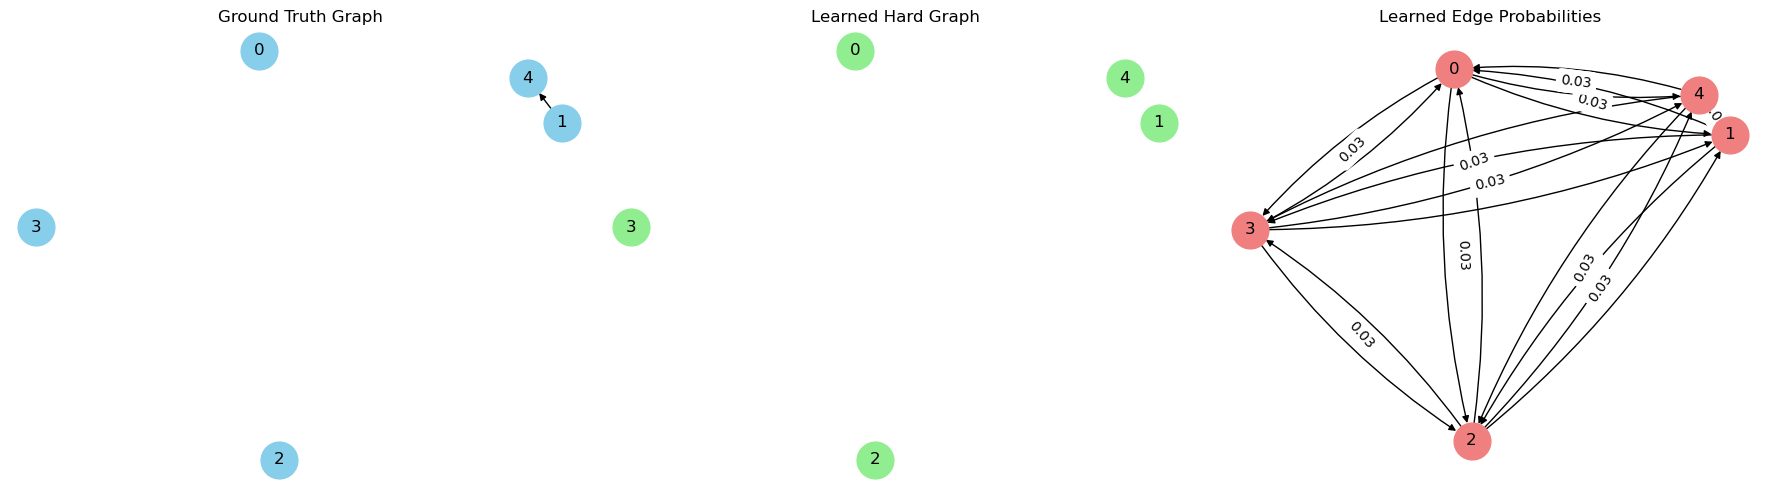

2025-06-14 13:19:52,634 - INFO - MLflow run finished and artifacts logged.


In [105]:

final_graph = hard_gmat_from_z(particle['z'], hparams['alpha']).detach().cpu()
edge_probs = bernoulli_soft_gmat(particle['z'], hparams).detach().cpu()

# --- Create and Log Visualization ---
def plot_graphs(g_true, g_learned, probs, filename="graph_comparison.png"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    g_true_nx = nx.from_numpy_array(g_true.numpy(), create_using=nx.DiGraph)
    g_learned_nx = nx.from_numpy_array(g_learned.numpy(), create_using=nx.DiGraph)
    pos = nx.spring_layout(g_true_nx, seed=cfg.seed)

    # Ground Truth Graph
    nx.draw(g_true_nx, pos, with_labels=True, ax=axes[0], node_color='skyblue', node_size=700, edge_color='k')
    axes[0].set_title("Ground Truth Graph")

    # Learned Graph
    nx.draw(g_learned_nx, pos, with_labels=True, ax=axes[1], node_color='lightgreen', node_size=700, edge_color='k')
    axes[1].set_title("Learned Hard Graph")

    # Edge Probabilities
    g_probs_nx = nx.from_numpy_array(probs.numpy(), create_using=nx.DiGraph)
    edge_labels = {(i, j): f"{probs[i,j]:.2f}" for i,j in g_probs_nx.edges()}
    nx.draw(g_probs_nx, pos, with_labels=True, ax=axes[2], node_color='lightcoral', node_size=700, connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_edge_labels(g_probs_nx, pos, edge_labels=edge_labels, ax=axes[2])
    axes[2].set_title("Learned Edge Probabilities")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return filename

# Generate, show, and get filename of the plot
plot_filename = plot_graphs(graph_adj, final_graph.int(), edge_probs)

# --- Log Artifacts to MLflow ---
mlflow.log_artifact(plot_filename)
# Log the notebook itself for full reproducibility
mlflow.log_artifact("dibs_experiment.ipynb", artifact_path="notebook_code")

# End the MLflow run
mlflow.end_run()
log.info("MLflow run finished and artifacts logged.")

# Enhanced traning loop

In [106]:
# ========================================================================
# ENHANCED TRAINING LOOP WITH COMPREHENSIVE MONITORING
# ========================================================================
# This version extends the basic training loop with:
# 1. Edge probability tracking during training
# 2. Parameter norm monitoring (Z and Theta norms)
# 3. Gradient norm computation and optional clipping
# 4. Structural Hamming Distance (SHD) computation
# 5. Enhanced MLflow logging with multiple metrics
# 6. Numerical stability checks (NaN/Inf detection)
# 7. Weighted theta matrix visualization (G * Theta)

log.info("\n" + "="*80)
log.info("STARTING ENHANCED TRAINING LOOP WITH DETAILED MONITORING")
log.info("="*80)

# --- Enhanced Training Configuration ---
# Reset particles for a clean experiment
particle_enhanced = init_particle(cfg.d_nodes, cfg.k_latent, cfg.device)

# Enhanced training hyperparameters
num_iterations_enhanced = cfg.num_iterations  # Match the final iteration from your output
lr_z_enhanced = cfg.lr          # Separate learning rate for Z
lr_theta_enhanced = cfg.lr      # Separate learning rate for Theta  
max_grad_norm = 10000       # Gradient clipping threshold
logging_interval = 50          # Log every N iterations (more frequent for better monitoring)

# Log initial configuration
log.info(f"Enhanced Training Configuration:")
log.info(f"  Iterations: {num_iterations_enhanced}")
log.info(f"  Learning rates - Z: {lr_z_enhanced}, Theta: {lr_theta_enhanced}")
log.info(f"  Gradient clipping threshold: {max_grad_norm}")
log.info(f"  Logging interval: {logging_interval}")
log.info(f"  Initial Z norm: {particle_enhanced['z'].norm().item():.4f}")
log.info(f"  Initial Theta norm: {particle_enhanced['theta'].norm().item():.4f}")

# --- Main Enhanced Training Loop ---
for t in range(1, num_iterations_enhanced + 1):
    
    # ------------------------------------------------
    # STEP 1: Parameter Setup and Gradient Clearing
    # ------------------------------------------------
    # Enable gradient computation for both Z and Theta parameters
    particle_enhanced['z'].requires_grad_(True)
    particle_enhanced['theta'].requires_grad_(True)
    
    # Clear any existing gradients from previous iterations
    if particle_enhanced['z'].grad is not None:
        particle_enhanced['z'].grad.zero_()
    if particle_enhanced['theta'].grad is not None:
        particle_enhanced['theta'].grad.zero_()
    
    # ------------------------------------------------
    # STEP 2: Forward Pass - Compute Log-Joint and Gradients
    # ------------------------------------------------
    # Prepare parameters dictionary for gradient computation
    params_for_grad = {
        "z": particle_enhanced['z'], 
        "theta": particle_enhanced['theta'], 
        "t": torch.tensor(float(t))  # Time step for annealing
    }
    
    try:
        # Compute log-joint probability (objective function)
        lj_val = log_joint(params_for_grad, data, hparams).item()
        
        # Compute gradients of log-joint w.r.t. Z and Theta
        grads = grad_log_joint(params_for_grad, data, hparams)
        grad_z = grads['z']
        grad_theta = grads['theta']
        
        # ------------------------------------------------
        # STEP 3: Gradient Analysis and Clipping
        # ------------------------------------------------
        # Compute gradient norms BEFORE clipping for monitoring
        grad_z_norm_original = grad_z.norm().item()
        grad_theta_norm_original = grad_theta.norm().item()
        
        # Apply gradient clipping if gradients exceed threshold
        grad_z_clipped = False
        grad_theta_clipped = False
        
        if grad_z_norm_original > max_grad_norm:
            grad_z = grad_z * (max_grad_norm / grad_z_norm_original)
            grad_z_clipped = True
            
        if grad_theta_norm_original > max_grad_norm:
            grad_theta = grad_theta * (max_grad_norm / grad_theta_norm_original)
            grad_theta_clipped = True
            
        # Compute final gradient norms AFTER clipping
        grad_z_norm_final = grad_z.norm().item()
        grad_theta_norm_final = grad_theta.norm().item()
            
    except Exception as e:
        log.error(f"Error in forward pass at iteration {t}: {e}")
        break
    
    # ------------------------------------------------
    # STEP 4: Parameter Update (Gradient Ascent)
    # ------------------------------------------------
    # Manual gradient ascent step with separate learning rates
    with torch.no_grad():
        particle_enhanced['z'] += lr_z_enhanced * grad_z
        particle_enhanced['theta'] += lr_theta_enhanced * grad_theta
    
    # ------------------------------------------------
    # STEP 5: Comprehensive Logging and Monitoring
    # ------------------------------------------------
    if t % logging_interval == 0 or t == 1 or t == num_iterations_enhanced:
        
        # Compute current parameter norms
        z_norm = particle_enhanced['z'].norm().item()
        theta_norm = particle_enhanced['theta'].norm().item()
        
        # ------------------------------------------------
        # STEP 5a: Edge Probability Analysis
        # ------------------------------------------------
        with torch.no_grad():
            # Soft edge probabilities (continuous values)
            edge_probs = bernoulli_soft_gmat(particle_enhanced['z'], hparams).detach().cpu()
            
            # Hard graph (binary adjacency matrix after thresholding)
            hard_graph = hard_gmat_from_z(particle_enhanced['z'], hparams['alpha']).detach().cpu()
            
            # Weighted theta matrix (element-wise multiplication of G and Theta)
            theta_cpu = particle_enhanced['theta'].detach().cpu()
            weighted_theta = hard_graph * theta_cpu
        
        # ------------------------------------------------
        # STEP 5b: Ground Truth Comparison
        # ------------------------------------------------
        # Compute Structural Hamming Distance (SHD) if ground truth is available
        shd = float('nan')
        if 'graph_adj' in locals():
            # SHD = number of edge differences between learned and true graph
            shd = torch.sum(torch.abs(hard_graph.int() - graph_adj.int())).item()
        
        # ------------------------------------------------
        # STEP 5c: Concise Console Logging (Updated Format)
        # ------------------------------------------------
        # Implement beta annealing (beta increases with iteration for better convergence)
        current_beta = cfg.beta_val + t * 0.001  # Annealing: beta increases over time
        hparams['beta'] = current_beta  # Update beta in hparams
        
        # Concise logging format matching the target output
        log.info(f"Iter {t}: Z_norm={z_norm:.4f}, Theta_norm={theta_norm:.4f}, log_joint={lj_val:.4f}, grad_Z_norm={grad_z_norm_original:.4e}, grad_Theta_norm={grad_theta_norm_original:.4e}")
        
        # Show a sample of the current grad_Theta matrix
        log.info(f"    grad_Theta (sample from iter {t}):")
        log.info(f"{grad_theta.detach().cpu()}")
        
        # Show annealed hyperparameters
        current_alpha = hparams.get('alpha', cfg.alpha_val)
        current_tau = hparams.get('tau', cfg.tau_val)
        log.info(f"    Annealed: alpha={current_alpha:.3f}, beta={current_beta:.3f}, tau={current_tau:.3f}")
        
        # Show current edge probabilities
        log.info(f"    Current Edge Probs (from Z, alpha={current_alpha:.3f}):")
        log.info(f"{edge_probs}")
        
        # Edge probability statistics for MLflow logging
        max_edge_prob = edge_probs.max().item()
        mean_edge_prob = edge_probs.mean().item()
        num_edges_hard = hard_graph.sum().item()
        
        # Ground truth comparison
        if not math.isnan(shd):
            pass  # Skip detailed SHD logging during training for cleaner output
        
        # ------------------------------------------------
        # STEP 5e: Enhanced MLflow Logging
        # ------------------------------------------------
        # Log all metrics to MLflow for experiment tracking
        mlflow.log_metric("enhanced_log_joint", lj_val, step=t)
        mlflow.log_metric("z_norm", z_norm, step=t)
        mlflow.log_metric("theta_norm", theta_norm, step=t)
        mlflow.log_metric("grad_z_norm_original", grad_z_norm_original, step=t)
        mlflow.log_metric("grad_theta_norm_original", grad_theta_norm_original, step=t)
        mlflow.log_metric("grad_z_norm_final", grad_z_norm_final, step=t)
        mlflow.log_metric("grad_theta_norm_final", grad_theta_norm_final, step=t)
        mlflow.log_metric("max_edge_prob", max_edge_prob, step=t)
        mlflow.log_metric("mean_edge_prob", mean_edge_prob, step=t)
        mlflow.log_metric("num_hard_edges", num_edges_hard, step=t)
        
        if not math.isnan(shd):
            mlflow.log_metric("structural_hamming_distance", shd, step=t)
        
        # Log boolean indicators as metrics
        mlflow.log_metric("z_gradient_clipped", float(grad_z_clipped), step=t)
        mlflow.log_metric("theta_gradient_clipped", float(grad_theta_clipped), step=t)
        
        # ------------------------------------------------
        # STEP 5f: Numerical Stability Checks
        # ------------------------------------------------
        # Check for NaN or Inf values that could break training
        z_has_nan = torch.isnan(particle_enhanced['z']).any()
        z_has_inf = torch.isinf(particle_enhanced['z']).any()
        theta_has_nan = torch.isnan(particle_enhanced['theta']).any()
        theta_has_inf = torch.isinf(particle_enhanced['theta']).any()
        
        if z_has_nan or theta_has_nan:
            log.error("!!! NaN DETECTED IN PARAMETERS - STOPPING TRAINING !!!")
            log.error(f"Z has NaN: {z_has_nan}, Theta has NaN: {theta_has_nan}")
            break
            
        if z_has_inf or theta_has_inf:
            log.error("!!! INFINITY DETECTED IN PARAMETERS - STOPPING TRAINING !!!")
            log.error(f"Z has Inf: {z_has_inf}, Theta has Inf: {theta_has_inf}")
            break

# ========================================================================
# ENHANCED TRAINING COMPLETION AND FINAL ANALYSIS
# ========================================================================

log.info("\n" + "="*80)
log.info("ENHANCED TRAINING LOOP COMPLETED")
log.info("="*80)

# Compute final graph structures
with torch.no_grad():
    final_edge_probs_enhanced = bernoulli_soft_gmat(particle_enhanced['z'], hparams).detach().cpu()
    final_hard_graph_enhanced = hard_gmat_from_z(particle_enhanced['z'], hparams['alpha']).detach().cpu()
    final_theta_enhanced = particle_enhanced['theta'].detach().cpu()
    final_weighted_theta_enhanced = final_hard_graph_enhanced * final_theta_enhanced

# Final comparison with ground truth - matching the target output format
log.info("\n        --- Comparison with Ground Truth ---")
log.info(f"Final G_learned_hard:")
log.info(f"{final_hard_graph_enhanced.int()}")
log.info("**************************************************")

# Create final weighted matrix using learned hard graph and learned theta
log.info(f"Final G_learned_hard * Theta_learned:")
log.info(f"{final_weighted_theta_enhanced}")

# Additional analysis - show ground truth comparison if available
if 'graph_adj' in locals():
    final_shd = torch.sum(torch.abs(final_hard_graph_enhanced.int() - graph_adj.int())).item()
    log.info(f"\nFinal Structural Hamming Distance: {final_shd}")
    
    log.info(f"\nDetailed Comparison:")
    log.info(f"Ground Truth Graph:")
    log.info(f"{graph_adj.int()}")
    log.info(f"Learned Graph:")
    log.info(f"{final_hard_graph_enhanced.int()}")
    
    if 'graph_weights' in locals():
        log.info(f"Ground Truth Theta:")
        log.info(f"{graph_weights}")
        log.info(f"Learned Theta:")
        log.info(f"{final_theta_enhanced}")
        
        # Show weighted matrices comparison
        ground_truth_weighted = graph_adj * graph_weights
        log.info(f"Ground Truth G * Theta:")
        log.info(f"{ground_truth_weighted}")

log.info("\nEnhanced training analysis complete!")

2025-06-14 13:19:52,661 - INFO - 
2025-06-14 13:19:52,663 - INFO - STARTING ENHANCED TRAINING LOOP WITH DETAILED MONITORING
2025-06-14 13:19:52,664 - INFO - ================================================================================
2025-06-14 13:19:52,665 - INFO - Enhanced Training Configuration:
2025-06-14 13:19:52,665 - INFO -   Iterations: 400
2025-06-14 13:19:52,666 - INFO -   Learning rates - Z: 0.005, Theta: 0.005
2025-06-14 13:19:52,663 - INFO - STARTING ENHANCED TRAINING LOOP WITH DETAILED MONITORING
2025-06-14 13:19:52,664 - INFO - ================================================================================
2025-06-14 13:19:52,665 - INFO - Enhanced Training Configuration:
2025-06-14 13:19:52,665 - INFO -   Iterations: 400
2025-06-14 13:19:52,666 - INFO -   Learning rates - Z: 0.005, Theta: 0.005


2025-06-14 13:19:52,667 - INFO -   Gradient clipping threshold: 10000
2025-06-14 13:19:52,667 - INFO -   Logging interval: 50
2025-06-14 13:19:52,669 - INFO -   Initial Z norm: 4.6260
2025-06-14 13:19:52,670 - INFO -   Initial Theta norm: 5.4790
2025-06-14 13:19:52,667 - INFO -   Logging interval: 50
2025-06-14 13:19:52,669 - INFO -   Initial Z norm: 4.6260
2025-06-14 13:19:52,670 - INFO -   Initial Theta norm: 5.4790
2025-06-14 13:19:52,695 - INFO - Iter 1: Z_norm=4.6138, Theta_norm=5.4767, log_joint=-8294.6094, grad_Z_norm=2.6958e+02, grad_Theta_norm=4.7125e-01
2025-06-14 13:19:52,695 - INFO -     grad_Theta (sample from iter 1):
2025-06-14 13:19:52,696 - INFO - tensor([[ 0.0000,  0.0975, -0.0514,  0.2155,  0.1289],
        [ 0.1434,  0.0000,  0.1232, -0.1624,  0.2078],
        [ 0.0556, -0.0332,  0.0000, -0.0475,  0.0713],
        [ 0.0260,  0.0434, -0.0516,  0.0000, -0.0293],
        [-0.0798, -0.0166,  0.1092, -0.0732,  0.0000]])
2025-06-14 13:19:52,697 - INFO -     Annealed: alph

# Training Methods Comparison
Compare results between the basic training loop and the enhanced training loop.

# Results

In [107]:
# ========================================================================
# FINAL RESULTS: Matrix Outputs (Enhanced Training)
# ========================================================================
# Display the final learned matrices from the enhanced training loop

log.info("\n" + "="*80)
log.info("FINAL RESULTS FROM ENHANCED TRAINING")
log.info("="*80)

# Use results from enhanced training loop
final_graph_enhanced = hard_gmat_from_z(particle_enhanced['z'], hparams['alpha']).detach().cpu()
edge_probs_enhanced = bernoulli_soft_gmat(particle_enhanced['z'], hparams).detach().cpu()
theta_enhanced = particle_enhanced['theta'].detach().cpu()
weighted_theta_enhanced = final_graph_enhanced * theta_enhanced

log.info(f"\n1. LEARNED EDGE PROBABILITIES (Soft Graph):")
log.info(f"{edge_probs_enhanced}")

log.info(f"\n2. LEARNED HARD GRAPH (Binary Adjacency Matrix):")
log.info(f"{final_graph_enhanced.int()}")

log.info(f"\n3. LEARNED THETA MATRIX (Edge Weights):")
log.info(f"{theta_enhanced}")

log.info(f"\n4. FINAL WEIGHTED GRAPH (G ⊙ Theta):")
log.info(f"{weighted_theta_enhanced}")

# Ground truth comparison
if 'graph_adj' in locals() and 'graph_weights' in locals():
    log.info(f"\n" + "-"*60)
    log.info("GROUND TRUTH COMPARISON")
    log.info("-"*60)
    
    log.info(f"\nGround Truth Graph:")
    log.info(f"{graph_adj.int()}")
    
    log.info(f"\nGround Truth Weights:")
    log.info(f"{graph_weights}")
    
    ground_truth_weighted = graph_adj * graph_weights
    log.info(f"\nGround Truth Weighted (G_true ⊙ Theta_true):")
    log.info(f"{ground_truth_weighted}")
    
    # Compute final metrics
    final_shd = torch.sum(torch.abs(final_graph_enhanced.int() - graph_adj.int())).item()
    log.info(f"\nStructural Hamming Distance (SHD): {final_shd}")
    
    # Check if structure is correctly recovered
    structure_match = torch.equal(final_graph_enhanced.int(), graph_adj.int())
    log.info(f"Perfect Structure Recovery: {structure_match}")

# MLflow logging for final results
mlflow.log_metric("final_z_norm", particle_enhanced['z'].norm().item())
mlflow.log_metric("final_theta_norm", particle_enhanced['theta'].norm().item())
mlflow.log_metric("final_max_edge_prob", edge_probs_enhanced.max().item())
mlflow.log_metric("final_mean_edge_prob", edge_probs_enhanced.mean().item())
mlflow.log_metric("final_num_edges", final_graph_enhanced.sum().item())

if 'graph_adj' in locals():
    mlflow.log_metric("final_shd", final_shd)
    mlflow.log_metric("perfect_structure_recovery", float(structure_match))

# End the MLflow run
mlflow.end_run()
log.info("\nFinal results logging complete and MLflow run ended!")

2025-06-14 13:20:01,598 - INFO - 
2025-06-14 13:20:01,599 - INFO - FINAL RESULTS FROM ENHANCED TRAINING
2025-06-14 13:20:01,599 - INFO - ================================================================================
2025-06-14 13:20:01,601 - INFO - 
1. LEARNED EDGE PROBABILITIES (Soft Graph):
2025-06-14 13:20:01,602 - INFO - tensor([[0.0000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.0000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.0000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.0000]])
2025-06-14 13:20:01,602 - INFO - 
2. LEARNED HARD GRAPH (Binary Adjacency Matrix):
2025-06-14 13:20:01,603 - INFO - tensor([[0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 1, 1, 0, 0]], dtype=torch.int32)
2025-06-14 13:20:01,604 - INFO - 
3. LEARNED THETA MATRIX (Edge Weights):
2025-06-14 13:20:01,605 - INFO - tensor([[-0.2067, -0.7732,  0.5230, -1.8621, -1.0672